In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 600
LOOK_AHEAD_LENGTH = 40

model = models.load_model("E-D-1k-600back-40forward")

In [7]:
def shapeData(data, length, look_ahead_length):

    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length:i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)

    #Reshape the input into (len(dataset), length, 1)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [8]:
def scaleData(dataset):
    scaler = MinMaxScaler()
    scaler = scaler.fit(dataset)
    
    dataset = scaler.transform(dataset)
    
    return (dataset, scaler)


In [9]:
def testModel(model, path_to_testing_dataset, quiet=False):
    
    df = pd.DataFrame()
    df["price"] = pd.read_csv(path_to_testing_dataset)[["high_price","low_price"]].mean(axis=1)
    dataset, scaler = scaleData(df)
    hist, _ = shapeData(dataset, LENGTH, LOOK_AHEAD_LENGTH)
    pred = model.predict(hist)

    if not quiet:
        plt.figure(figsize=(24,8))
        plt.plot(df.head(2500), color='blue', label='Price')

        for i in np.arange(0, 1000, 100):
            pred_transformed = scaler.inverse_transform(pred[i])

            plt.plot(np.arange(LENGTH+i,LENGTH+LOOK_AHEAD_LENGTH+i),pred_transformed, color='red', label='Prediction')
        
        plt.title('Predicted price movements')
        plt.show()

    return


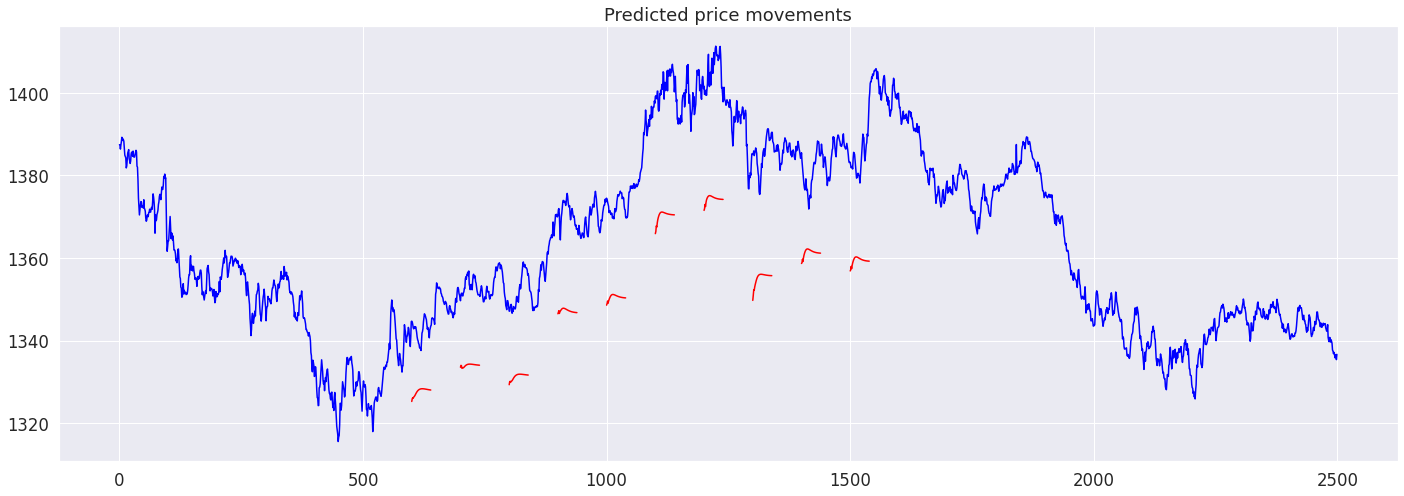

In [10]:
testModel(model, "../../data/ETH.csv")

# Single Prediction

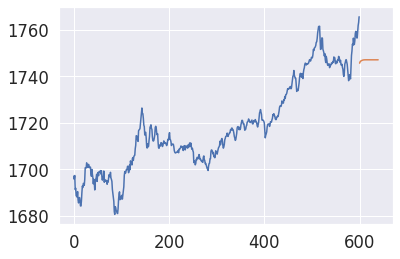

In [11]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
whole_df = pd.read_csv('../../data/ETH.csv')
# most_recent_period = np.array(recent_history)
recent_history = pd.DataFrame({'price': whole_df[["high_price","low_price"]].mean(axis=1)}).tail(length)
recent_history = recent_history.set_index(pd.DatetimeIndex(pd.to_datetime(whole_df['begins_at'].tail(length))))

# 2. convert to numpy array 
most_recent_period = np.array(recent_history)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)
# print(prediction[0])
# 6. Un-normalize the data
result = scaler.inverse_transform(prediction[0])
recent_history_unscaled = scaler.inverse_transform(most_recent_period_scaled)
recent_history.price = recent_history_unscaled

# print(result)
pred_df = pd.DataFrame(result)
# pred_df = pred_df.set_index(pd.DatetimeIndex(pd.date_range(recent_history.index[-1], periods=len(result[0]), freq="15s")))

plt.plot(recent_history_unscaled)
plt.plot(np.arange(length, length+LOOK_AHEAD_LENGTH),result)
plt.show()